# Olympic Medals

## Visual Data Science

Clara Pichler, 11917694

### Overview

1. Introduction
- Original Research Questions
- Used Datasets
- Requirements & Dependencies

2. Data Preprocessing
- Loading in the Data Sets
- First Steps
- Missing Values - Part 1
- Merging Data Sets
- Missing Values - Part 2

3. Data Exploration


### Notes

Bis 16.12

__Wrangle:__ 
- Join the two or more datasets you selected into one big data table, and
- Solve issues like formatting issues, missing data, faulty values, and non-matching keys
- _10 points_ extra, if you can (visually!) show and explain the data quality of your dataset (for example, before and after cleaning steps). There are no instructions how such a visualization should look like, since this also highly depends on the chosen domain and data. You will have to come up with your own, creative, solution here.

__Profile:__
- Find at least 3 valuable insights.
- Show the insights by using visualization.

In the Profile part, you will have to explore the data in detail, to completely understand its structure, and to discover any interesting patterns that can be found in there. The following steps are required:

- Find at least 3 informative insights in your dataset, and
- Show and explain the insights using visualizations (one visualization per insight).



## Introduction



### Original Research Questions

- Are there any similarities between countries which win medals often in specific kinds of sports?
- Which factors influence the amount of medals a country wins? 
- Is it possible to predict the number of won medals of a country?
- Are there any trends in the medal distribution over time?
- Which factors play a part in the "under-dog" countries winning suddenly some medals?


### Used Data Sets

__Olympics Medals Data Set__
- _description:_ General information on medalists (Athlete or Team)
- _source:_ https://www.kaggle.com/datasets/piterfm/olympic-games-medals-19862018
- _note:_ This data set comes with three other data sets that include information on the athletes, hosts and all of the results. I will only focus on the medals so first, second and third place, therefore only using the `olympic_medals.csv` data set. 
- _disadvantages:_ Quote from the description
    - "There are no results for qualification rounds. For instance, event 100-m men contains only final results without semi-finals and other hits."
    - "There is no information about athletes for team competitions that consist of more than 2 participants. Only team records."

__Elevation Extremes Data Set__
- _description:_ A sortable table which lists land surface elevation extremes by country or dependent territory
- _source:_ https://en.wikipedia.org/wiki/List_of_elevation_extremes_by_country 
- 

__World Climate Data__
- _description:_ List of all countries and territories in the world with climate zones and average annual temperatures.
- _source:_ https://weatherandclimate.com/countries 
- 

__World Bank Data__
- _description:_ giving me data on the gdp on countries
- _source:_ https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.CD&country

### Requirements & Dependencies

This project was created using Python 3.12.5. The exact versions of the dependencies can be installed with the following command.

In [1264]:
%pip install -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [1301]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests as r
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

## Data Pre-Processing



### Loading in the Data Sets

First and foremost we will load in our data sets. 

For the elevation data set which I got from Wikipedia, I used `BeautifulSoup` to scrape the table from their website. I treid firts `pd.read_html` however this simple approach did not work for me like it did for others.

In [1302]:
df_olympics = pd.read_csv('data/olympics/olympic_medals.csv')
df_world = pd.read_csv('data/World_Development_Indicators/World_Bank_Data.csv')

In [1303]:
url = "https://en.wikipedia.org/wiki/List_of_elevation_extremes_by_country"
response = r.get(url)
wiki_page_text = response.text

In [1304]:
response.status_code # 200 means everything is A-OK

200

In [1305]:
soup = BeautifulSoup(wiki_page_text, 'html.parser')
elevation_table = soup.find('table',{'class':'wikitable sortable sticky-header-multi plainrowheaders'})

headers = [header.text.strip() for header in elevation_table.find_all('th')]

rows = []
for row in elevation_table.find_all('tr')[1:]:  
    cells = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
    rows.append(cells)

df_elevation = pd.DataFrame(rows, columns=headers)

In [1306]:
url = "https://weatherandclimate.com/countries"
response = r.get(url)
wiki_page_text = response.text
response.status_code # 200 means everything is A-OK

200

In [1307]:
soup = BeautifulSoup(wiki_page_text, 'html.parser')
elevation_table = soup.find('table',{'class':'tb1'})

headers = [header.text.strip() for header in elevation_table.find_all('th')]

rows = []
for row in elevation_table.find_all('tr')[1:]:  
    cells = [cell.text.strip() for cell in row.find_all(['td', 'th'])]
    rows.append(cells)

df_climate = pd.DataFrame(rows, columns=headers)

### First Steps

First we will take a first look at the `df_olympics` dataframe. We will drop unnecessary columns like `athlete_url`, `country_code` and `country_3_letter_code`. I was planning on merging on the ISOCode, however, I realized it was not quite right (example Zimbabwe shpuld be ZWE, but is ZIM). I do not care about the host country so I changed the `slug_game` attribute to `year` and left out the host name. The type was changed to `int`, all other types are fine. Maybe we will change `medal_type` gold, silver and bronze to 1, 2, and 3 in the future for making it easier to work with. 

I also drop the column `athlete_full_name` which will result in rows that are not unique since for events with the `participant_type`: `GameTeam` we have a medal entry for each athlete in the team. Thats why I use `drop_duplicates()`.


In [1308]:
df_olympics = df_olympics.drop(['athlete_url', 'country_code', 'participant_title', 'athlete_full_name', 'country_3_letter_code'], axis=1).drop_duplicates()

df_olympics = df_olympics.rename(columns={
    'slug_game': 'year',
})

df_olympics['year'] = df_olympics['year'].str[-4:].astype(int)

df_olympics = df_olympics.reset_index(drop=True)


In [1309]:
display(df_olympics.head(5))
display(df_olympics.info())
print(df_olympics['year'].unique())

,discipline_title,year,event_title,event_gender,medal_type,participant_type,country_name
0,Curling,2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy
1,Curling,2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway
2,Curling,2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden
3,Curling,2022,Women,Women,GOLD,GameTeam,Great Britain
4,Curling,2022,Women,Women,SILVER,GameTeam,Japan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20171 entries, 0 to 20170
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   discipline_title  20171 non-null  object
 1   year              20171 non-null  int64 
 2   event_title       20171 non-null  object
 3   event_gender      20171 non-null  object
 4   medal_type        20171 non-null  object
 5   participant_type  20171 non-null  object
 6   country_name      20171 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.1+ MB


None

[2022 2020 2018 2016 2014 2012 2010 2008 2006 2004 2002 2000 1998 1996
 1994 1992 1988 1984 1980 1976 1972 1968 1964 1960 1956 1952 1948 1936
 1932 1928 1924 1920 1912 1908 1904 1900 1896]


To make it a bit easier for us, we consider the olympic games from 1980 till 2022.

In [1310]:
df_olympics = df_olympics[df_olympics['year'] > 1980]

Moving on with `df_elevation`. The attributes `Highest point` and `Lowest point` ist non of my interest from this data set. 

In [1311]:
df_elevation = df_elevation.drop(['Highest point', 'Lowest point'], axis=1)

df_elevation = df_elevation.rename(columns={
    'Continent' : 'continent',
    'Country or region': 'country_name',
    'Maximum elevation': 'max_elevation',
    'Minimum elevation': 'min_elevation',
    'Elevation span' : 'elevation_span'
})

In [1312]:
df_elevation = df_elevation.replace("sea level", "0")

for col in ['max_elevation', 'min_elevation', 'elevation_span']: 
    df_elevation[col] = (df_elevation[col].str.split('m')
                         .str[0].str.strip()
                         .str.replace('−', '-', regex=False)
                         .str.replace(',', '.', regex=False))
    df_elevation.replace({col : ''}, np.nan, inplace=True)
    df_elevation[col] = df_elevation[col].astype(float)

In [1313]:
display(df_elevation.head(5))
display(df_elevation.info())

,country_name,continent,max_elevation,min_elevation,elevation_span
0,Afghanistan,Asia,7492.0,258.0,7234.0
1,Albania,Europe,2764.0,0.0,2764.0
2,Algeria,Africa,3003.0,-40.0,3043.0
3,American Samoa,Oceania,966.0,0.0,966.0
4,Andorra,Europe,2942.0,840.0,2102.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country_name    254 non-null    object 
 1   continent       254 non-null    object 
 2   max_elevation   254 non-null    float64
 3   min_elevation   253 non-null    float64
 4   elevation_span  253 non-null    float64
dtypes: float64(3), object(2)
memory usage: 10.1+ KB


None

Now we look at the data set that gives us information the climate zones of the countries.

In [1314]:
df_climate = df_climate.rename(columns={
    'Country' : 'country_name',
    'Climate zone' : 'climate_zone',
    'Avg °C' : 'avg_celsius',
})

df_climate = df_climate.drop('Avg °F', axis=1)
df_climate['avg_celsius'] = df_climate['avg_celsius'].apply(lambda x : np.nan if x == '' else float(x))
df_climate = df_climate.replace('', np.nan)

In [1315]:
display(df_climate.head(5))
display(df_climate.info())
display(df_climate['climate_zone'].unique(), len(df_climate['climate_zone'].unique()))

,country_name,climate_zone,avg_celsius
0,Afghanistan,DSB,15.70
1,Albania,CSB,15.17
2,Algeria,BWH,20.00
3,American Samoa,AW,28.00
4,Andorra,CFB,7.17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  246 non-null    object 
 1   climate_zone  246 non-null    object 
 2   avg_celsius   244 non-null    float64
dtypes: float64(1), object(2)
memory usage: 5.9+ KB


None

array(['DSB', 'CSB', 'BWH', 'AW', 'CFB', 'AF', 'CFA', 'DFB', 'BSK', 'AM',
       'CWB', 'BS', 'BSH', 'DFC', 'CWA', 'ET', 'CFC', 'CSA', 'EF', 'BWK',
       'DWB', 'AS', 'DSC'], dtype=object)

23

As the last data set we have the World Bank Data. 

In [1316]:
df_world = df_world.dropna(subset = ['Country Name', 'Country Code'])
df_world = df_world[df_world['Series Name'] == 'GDP (current US$)']

df_world = df_world.drop('2023 [YR2023]', axis=1)

In [1317]:
gdp_data = []

for year in df_world.drop(['Series Name', 'Series Code', 'Country Name', 'Country Code'], axis=1).columns:
    for country in df_world['Country Code'].unique():

        if df_world[df_world['Country Code']==country][year].values[0] == '..':
            gdp_data.append({
                "country_name" : df_world[df_world['Country Code']==country]['Country Name'].values[0],
                "isocode" : country,
                "year" : int(year.split()[0]),
                "gdp" : np.nan
            })
        else:
            gdp_data.append({
                "country_name" : df_world[df_world['Country Code']==country]['Country Name'].values[0],
                "isocode" : country,
                "year" : int(year.split()[0]),
                "gdp" : float(df_world[df_world['Country Code']==country][year].values[0])
            })

df_gdp = pd.DataFrame(gdp_data)

In [1318]:
display(df_gdp.head(5))
display(df_gdp.info())

,country_name,isocode,year,gdp
0,Afghanistan,AFG,1976,NaN
1,Albania,ALB,1976,NaN
2,Algeria,DZA,1976,1.772824e+10
3,American Samoa,ASM,1976,NaN
4,Andorra,AND,1976,2.272839e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10199 entries, 0 to 10198
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  10199 non-null  object 
 1   isocode       10199 non-null  object 
 2   year          10199 non-null  int64  
 3   gdp           8978 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 318.8+ KB


None

### Missing Values - Part 1

We will handle some of the missing values before merging, since after merging we will loose some information that can help with imputing missing values.

Some countries are written differently, that is why we need to rename some of them. Of course everything would be easier if every table would have come with an ISOCode. BUT something that is great is the ISOCode of some of the countries in the `df_olympics` are wrong anyways, so for the World Bank Data set I also have to chnage the country names.

In [1319]:
rename_olympics = { 
    'United Republic of Tanzania' : 'Tanzania',
    'Federal Republic of Germany' : "Germany",
    'German Democratic Republic (Germany)' : "Germany",
    'Netherlands Antilles' : "Netherlands",
    'Olympic Athletes from Russia' : "Russia",
    "People's Republic of China" : "China",
    'ROC' : "Taiwan",
    'Great Britain' : "United Kingdom",
    "Democratic People's Republic of Korea" : "North Korea",
    "Republic of Korea": "South Korea",
    "Russian Federation" : "Russia",
    "United States of America" :"United States",
    "Islamic Republic of Iran" : "Iran",
    'Chinese Taipei' : "Taiwan",
    'Syrian Arab Republic' : "Syria",
    "Republic of Moldova": "Moldova",
    'United Republic of Tanzania' : 'Tanzania',
}

rename_elevation = {
    "Ivory Coast": "Côte d'Ivoire",
    'United States Virgin Islands': 'Virgin Islands, US',
    'Morocco[ae]' : "Morocco",  
    'Hong Kong' : 'Hong Kong, China',
    'China[h]' : 'China',
    'Taiwan[ar]' : 'Taiwan',
}

rename_climate = {
    "Cote D'Ivoire": "Côte d'Ivoire",
    'Hong Kong' : 'Hong Kong, China',
    "US Virgin Islands": "Virgin Islands, US",
    "Czechia": "Czech Republic",
    'The Bahamas' : 'Bahamas',
}

rename_gdp = {
    'Virgin Islands (U.S.)' : "Virgin Islands, US",
    'Bahamas, The' : 'Bahamas',
    'Czechia' : 'Czech Republic',
    "Cote d'Ivoire" : "Côte d'Ivoire",
    'Egypt, Arab Rep.' : 'Egypt',
    'Hong Kong SAR, China' : 'Hong Kong, China',
    'Iran, Islamic Rep.' : 'Iran',
    'Kyrgyz Republic' : 'Kyrgyzstan',
    "Korea, Dem. People's Rep." : 'North Korea',
    'Russian Federation' :'Russia',
    'Slovak Republic' : 'Slovakia',
    'Korea, Rep.' : 'South Korea',
    'Syrian Arab Republic' : 'Syria',
    'Turkiye' : 'Turkey',
    'Venezuela, RB' : 'Venezuela',
    'Viet Nam' : 'Vietnam',
}

df_elevation['country_name'] = df_elevation['country_name'].replace(rename_elevation)
df_climate['country_name'] = df_climate['country_name'].replace(rename_climate)
df_olympics['country_name'] = df_olympics['country_name'].replace(rename_olympics)
df_gdp['country_name'] = df_gdp['country_name'].replace(rename_gdp)

A problem I was not expecting is that the World Bank Data does not include an entry for Taiwan. I will add an entry for Taiwan and figure it out once I am concerning myself with missing values.

In [1320]:
for year in df_gdp['year'].unique():
    df_gdp.loc[len(df_gdp)] = ['Taiwan', 'TWN', year, np.nan]

Some of the countries that have played in the olympic games are not existing anymore. Those are the following:

Czechoslovakia, Serbia and Montenegro, Soviet Union and Yugoslavia

I used the internet to collect the countries which were part of these former countries and used the minimum (maximum) elevation of those to fill in the missing data for the elevation data set.

For the climate I averaged over all of their average celsius (again this feature will probably not be telling us a lot) and for the climate zone I looked at the median and filled those in:

- 'Yugoslavia' = CFB
- 'Serbia and Montenegro' = CFB
- 'Czechoslovakia' = C or DFB? 
- 'Soviet Union' = DFB or DFC 

For the specific teams for the Olympics Unified Team and Independent Olympic Athletes I looked at their participating year and considered the values of the countries the athletes are usually participating for.

- Independent Olympic Athletes - 1992 all from serbia, 2016 both kuwait
- Unified Team - in year 1992 (only data points from then) is Soviet Union

In [1321]:
countries_yugo = ['Slovenia', 'Croatia', 'Serbia', 'Montenegro', 'Bosnia and Herzegovina', 'North Macedonia']
countries_se_mo = ['Serbia', 'Montenegro']
countries_cz = ['Czech Republic', 'Slovakia']
countries_sov = ['Russia', 'Ukraine', 'Belarus', 'Moldova', 'Kazakhstan', 'Estonia', 'Latvia', 'Lithuania']


max_el, min_el = -1000, 1000
avg_yugo = 0

for country in countries_yugo:
    if max_el < df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]:
        max_el = df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]
    
    if min_el > df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]:
        min_el = df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]
    
    avg_yugo = avg_yugo + df_climate[df_climate['country_name']==country]['avg_celsius'].values[0]
    el_span = max_el - min_el

avg_yugo = avg_yugo/len(countries_yugo)
df_elevation.loc[len(df_elevation)] = ['Yugoslavia', 'Europe', max_el, min_el, el_span]


max_el, min_el = -1000, 1000
avg_se_mo = 0

for country in countries_se_mo:
    if max_el < df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]:
        max_el = df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]
    
    if min_el > df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]:
        min_el = df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]
    
    avg_se_mo = avg_se_mo + df_climate[df_climate['country_name']==country]['avg_celsius'].values[0]
    el_span = max_el - min_el

avg_se_mo = avg_se_mo/len(countries_se_mo)
df_elevation.loc[len(df_elevation)] = ['Serbia and Montenegro', 'Europe', max_el, min_el, el_span]


max_el, min_el = -1000, 1000
avg_cz = 0

for country in countries_cz:
    if max_el < df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]:
        max_el = df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]
    
    if min_el > df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]:
        min_el = df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]
    
    avg_cz = avg_cz + df_climate[df_climate['country_name']==country]['avg_celsius'].values[0]
    el_span = max_el - min_el

avg_sov = avg_cz/len(countries_cz)
df_elevation.loc[len(df_elevation)] = ['Czechoslovakia', 'Europe', max_el, min_el, el_span]


max_el, min_el = -1000, 1000
avg_sov = 0

for country in countries_sov:
    if max_el < df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]:
        max_el = df_elevation[df_elevation['country_name']==country]['max_elevation'].values[0]
    
    if min_el > df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]:
        min_el = df_elevation[df_elevation['country_name']==country]['min_elevation'].values[0]
    
    avg_sov = avg_sov + df_climate[df_climate['country_name']==country]['avg_celsius'].values[0]
    el_span = max_el - min_el

avg_sov = avg_sov/len(countries_sov)
df_elevation.loc[len(df_elevation)] = ['Soviet Union', 'Asia', max_el, min_el, el_span]
df_elevation.loc[len(df_elevation)] = ['Unified Team', 'Asia', max_el, min_el, el_span]


In [1322]:
df_climate.loc[len(df_climate)] = ['Yugoslavia', 'CFB', avg_yugo]
df_climate.loc[len(df_climate)] = ['Serbia and Montenegro', 'CFB', avg_se_mo]
df_climate.loc[len(df_climate)] = ['Czechoslovakia', 'CFB', avg_cz]
df_climate.loc[len(df_climate)] = ['Soviet Union', 'DFB', avg_sov]
df_climate.loc[len(df_climate)] = ['Unified Team', 'DFB', avg_sov]

In [1323]:
display(df_elevation.tail(5))
display(df_climate.tail(5))

,country_name,continent,max_elevation,min_elevation,elevation_span
254,Yugoslavia,Europe,2864.0,0.0,2864.0
255,Serbia and Montenegro,Europe,2534.0,0.0,2534.0
256,Czechoslovakia,Europe,2655.0,94.0,2561.0
257,Soviet Union,Asia,7010.0,-132.0,7142.0
258,Unified Team,Asia,7010.0,-132.0,7142.0


,country_name,climate_zone,avg_celsius
246,Yugoslavia,CFB,12.733333
247,Serbia and Montenegro,CFB,12.745000
248,Czechoslovakia,CFB,20.850000
249,Soviet Union,DFB,8.947500
250,Unified Team,DFB,8.947500


country_name       0
isocode            0
year               0
gdp             1268
dtype: int64

<Axes: >

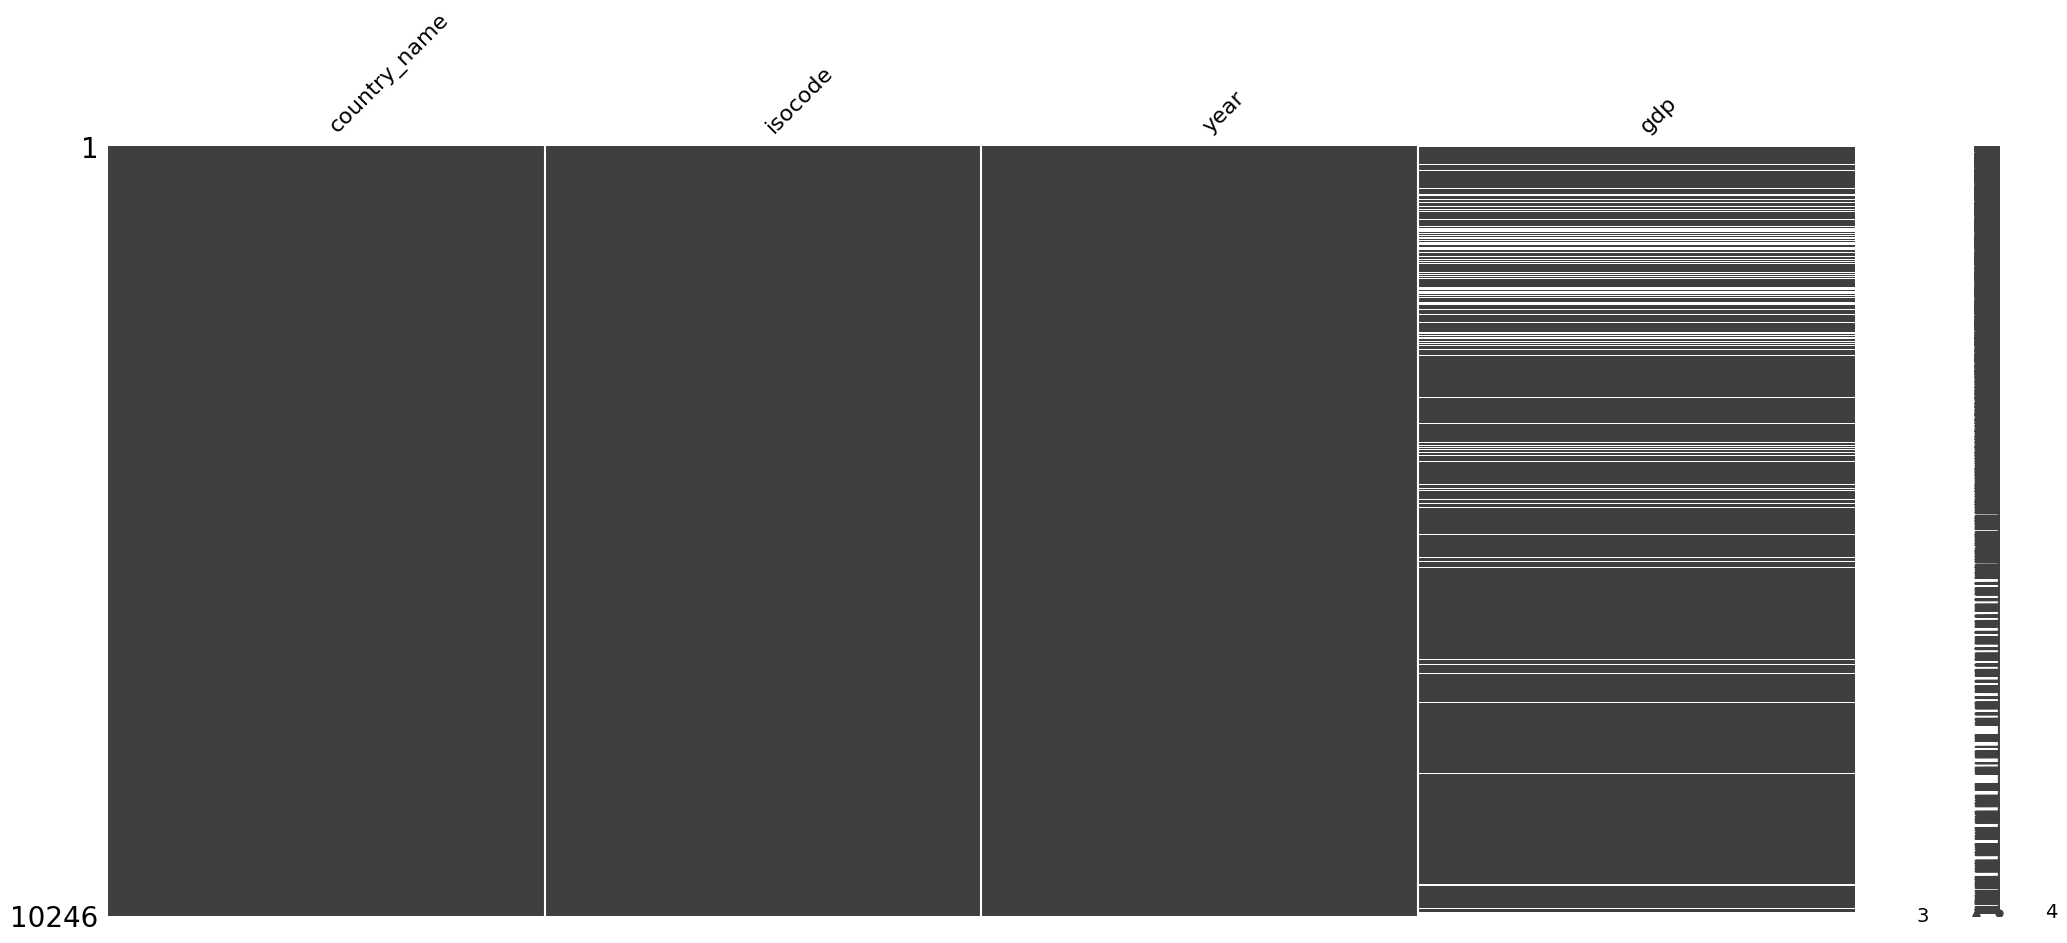

In [1324]:
display(df_gdp.isna().sum())
display(msno.matrix(df_gdp))

In [1325]:
temp_list = []

for country in df_gdp['isocode'].unique():
    df_gdp_country = df_gdp[df_gdp['isocode']==country]
    df_gdp_country = df_gdp_country.assign(gdp_new = df_gdp_country['gdp'].interpolate(method='linear', limit_direction='both'))

    temp_list.append(df_gdp_country)

df_gdp_interpolate = pd.concat(temp_list, ignore_index=True)
df_gdp_interpolate = df_gdp_interpolate.drop('gdp', axis = 1)

In [1326]:
df_gdp_interpolate[df_gdp_interpolate['gdp_new'].isna()]['country_name'].unique()

array(['British Virgin Islands', 'Gibraltar', 'North Korea', 'Taiwan'],
      dtype=object)

In [1327]:
df_gdp_interpolate = df_gdp_interpolate[~df_gdp_interpolate['country_name'].isin(['British Virgin Islands', 'Gibraltar', 'North Korea', 'Taiwan'])]

<Axes: >

country_name    0
isocode         0
year            0
gdp_new         0
dtype: int64

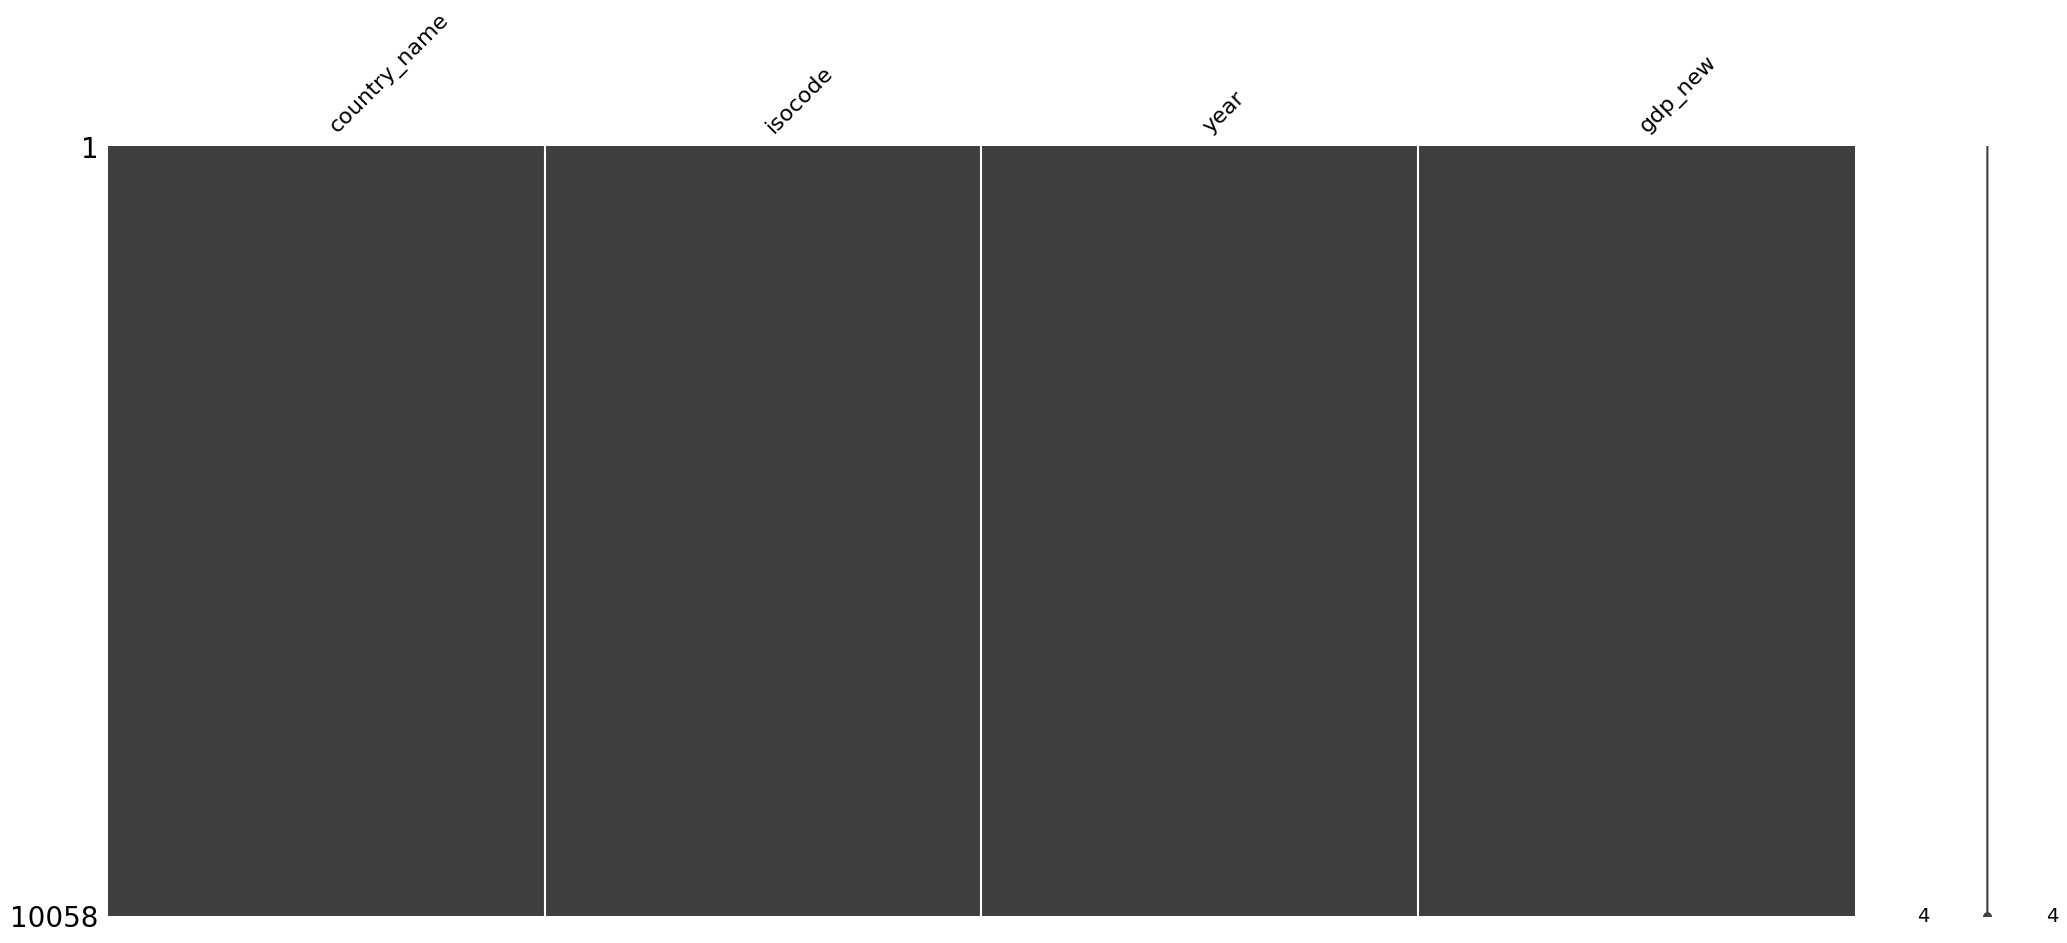

In [1328]:
display(msno.matrix(df_gdp_interpolate))
display(df_gdp_interpolate.isna().sum())

### Merging

In [1329]:
df_merged = pd.merge(df_olympics, df_elevation, how='left', on='country_name')
df_merged = pd.merge(df_merged, df_climate, how='left', on='country_name')
df_merged = pd.merge(df_merged, df_gdp_interpolate, how='left', on=['country_name', 'year'])

In [1330]:
display(df_merged.head(5))
display(df_merged.info())

,discipline_title,year,event_title,event_gender,medal_type,participant_type,country_name,continent,max_elevation,min_elevation,elevation_span,climate_zone,avg_celsius,isocode,gdp_new
0,Curling,2022,Mixed Doubles,Mixed,GOLD,GameTeam,Italy,Europe,4810.0,-3.0,4813.0,CSA,14.47,ITA,2.066972e+12
1,Curling,2022,Mixed Doubles,Mixed,SILVER,GameTeam,Norway,Europe,2469.0,0.0,2469.0,DFC,5.03,NOR,5.937270e+11
2,Curling,2022,Mixed Doubles,Mixed,BRONZE,GameTeam,Sweden,Europe,2097.0,-2.0,2099.0,DFB,7.25,SWE,5.904096e+11
3,Curling,2022,Women,Women,GOLD,GameTeam,United Kingdom,Europe,1345.0,-4.0,1349.0,CFB,10.75,GBR,3.088840e+12
4,Curling,2022,Women,Women,SILVER,GameTeam,Japan,Asia,3776.0,-4.0,3780.0,DFB,15.19,JPN,4.256411e+12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11378 entries, 0 to 11377
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   discipline_title  11378 non-null  object 
 1   year              11378 non-null  int64  
 2   event_title       11378 non-null  object 
 3   event_gender      11378 non-null  object 
 4   medal_type        11378 non-null  object 
 5   participant_type  11378 non-null  object 
 6   country_name      11378 non-null  object 
 7   continent         11373 non-null  object 
 8   max_elevation     11373 non-null  float64
 9   min_elevation     11373 non-null  float64
 10  elevation_span    11373 non-null  float64
 11  climate_zone      11373 non-null  object 
 12  avg_celsius       11373 non-null  float64
 13  isocode           10802 non-null  object 
 14  gdp_new           10802 non-null  float64
dtypes: float64(5), int64(1), object(9)
memory usage: 1.3+ MB


None

### Missing Values - Part 2

Some missing values are better to handle after merging since it depends on features of other dataframes.

discipline_title      0
year                  0
event_title           0
event_gender          0
medal_type            0
participant_type      0
country_name          0
continent             5
max_elevation         5
min_elevation         5
elevation_span        5
climate_zone          5
avg_celsius           5
isocode             576
gdp_new             576
dtype: int64

<Axes: >

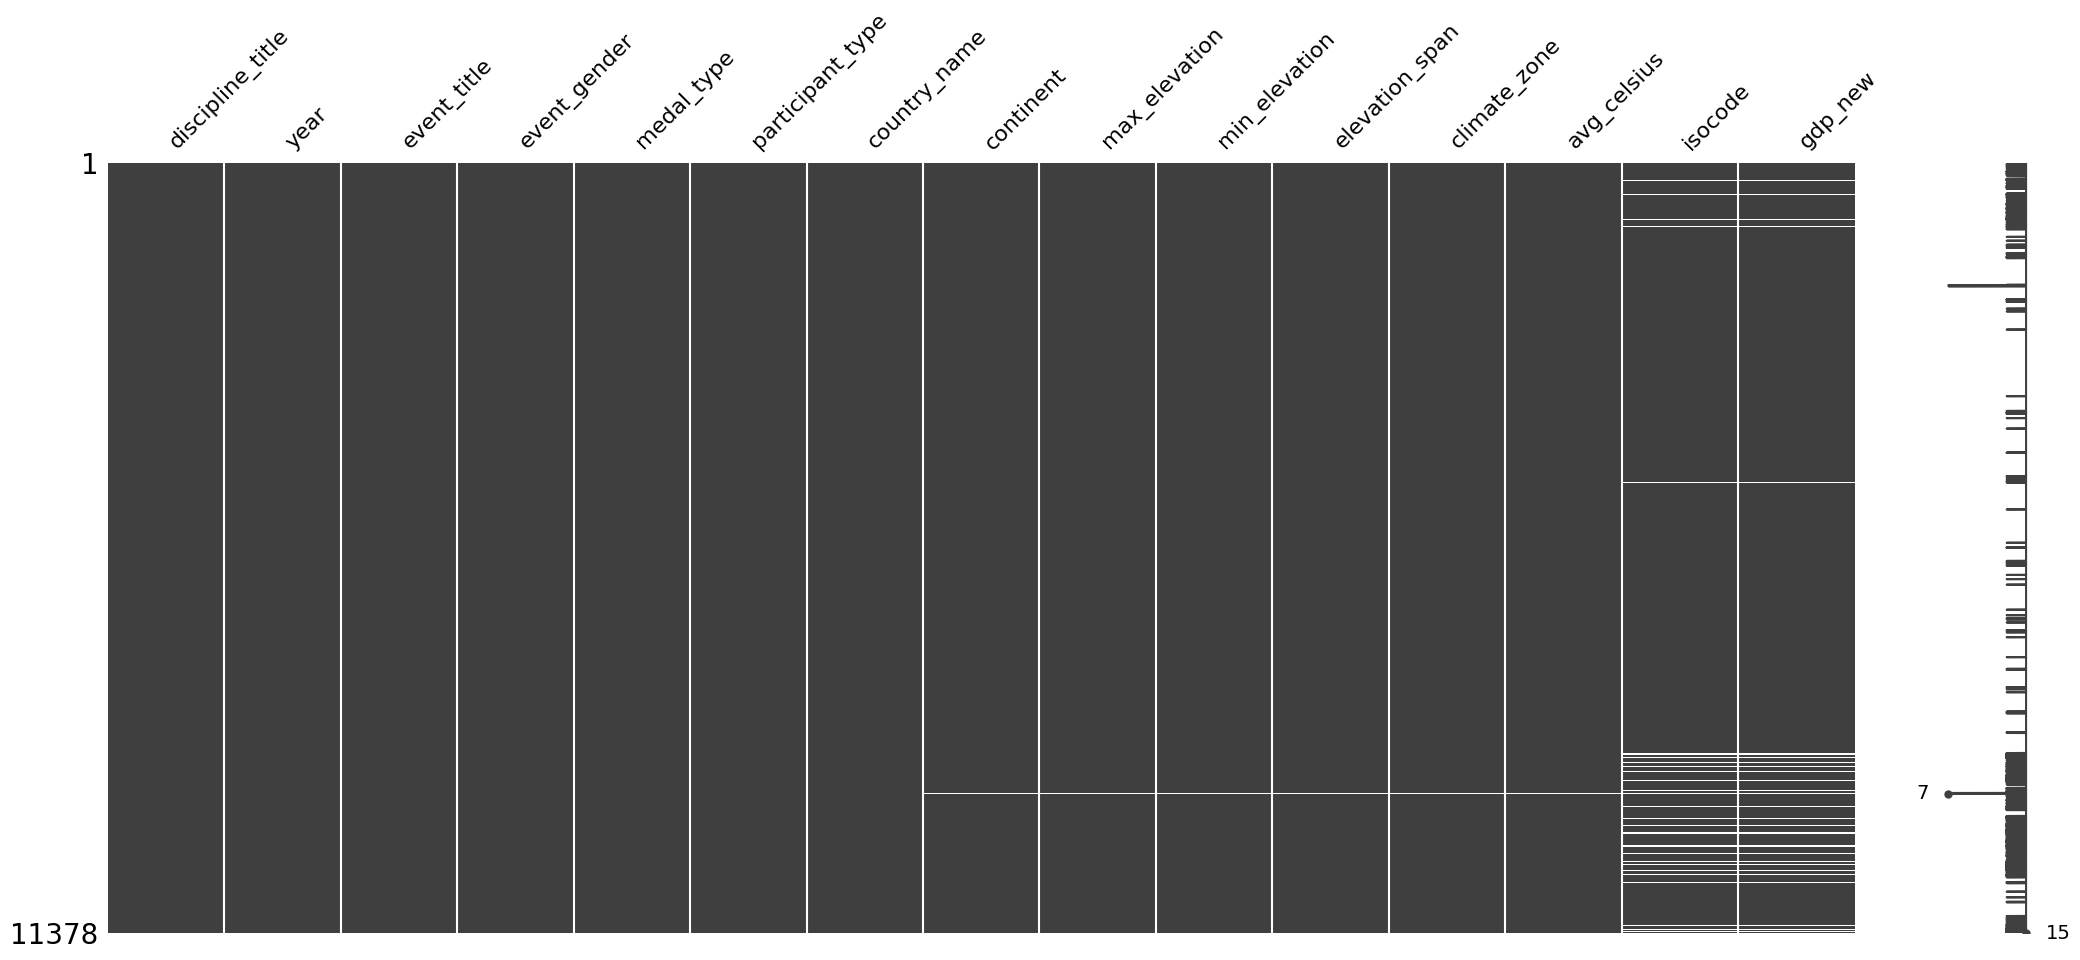

In [1331]:
display(df_merged.isna().sum())
msno.matrix(df_merged)

In [1332]:
display(df_merged[df_merged['max_elevation'].isna()])

,discipline_title,year,event_title,event_gender,medal_type,participant_type,country_name,continent,max_elevation,min_elevation,elevation_span,climate_zone,avg_celsius,isocode,gdp_new
1804,Shooting,2016,double trap 150 targets men,Men,GOLD,Athlete,Independent Olympic Athletes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1821,Shooting,2016,skeet (125 targets) men,Men,BRONZE,Athlete,Independent Olympic Athletes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9308,Shooting,1992,10m air rifle 40 shots women,Women,BRONZE,Athlete,Independent Olympic Athletes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9314,Shooting,1992,50m rifle prone 60 shots men,Men,BRONZE,Athlete,Independent Olympic Athletes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9316,Shooting,1992,10m air pistol 40 shots women,Women,SILVER,Athlete,Independent Olympic Athletes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1333]:
columns_el = ['continent', 'max_elevation', 'min_elevation', 'elevation_span']
columns_climate = ['climate_zone', 'avg_celsius']

for col in columns_el:
    df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 1992), col] = df_elevation.loc[df_elevation['country_name']=='Serbia', col].squeeze()
    df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 2016), col] = df_elevation.loc[df_elevation['country_name']=='Kuwait', col].squeeze()

for col in columns_climate:
    df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 1992), col] = df_climate.loc[df_climate['country_name']=='Serbia', col].squeeze()
    df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 2016), col] = df_climate.loc[df_climate['country_name']=='Kuwait', col].squeeze()

df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 1992), 'gdp_new'] = df_gdp_interpolate.loc[(df_gdp_interpolate['country_name']=='Serbia') & (df_gdp_interpolate['year'] == 1992), 'gdp_new'].squeeze()
df_merged.loc[(df_merged['country_name']== 'Independent Olympic Athletes') & (df_merged['year'] == 2016), 'gdp_new'] = df_gdp_interpolate.loc[(df_gdp_interpolate['country_name']=='Kuwait') & (df_gdp_interpolate['year'] == 2016), 'gdp_new'].squeeze()

df_merged.loc[df_merged['country_name']== 'Independent Olympic Athletes', 'isocode'] = 'IOA'


In [1334]:
display(df_merged[df_merged['country_name']== 'Independent Olympic Athletes'])

,discipline_title,year,event_title,event_gender,medal_type,participant_type,country_name,continent,max_elevation,min_elevation,elevation_span,climate_zone,avg_celsius,isocode,gdp_new
1804,Shooting,2016,double trap 150 targets men,Men,GOLD,Athlete,Independent Olympic Athletes,Asia,291.0,0.0,291.0,BWH,28.83,IOA,1.094067e+11
1821,Shooting,2016,skeet (125 targets) men,Men,BRONZE,Athlete,Independent Olympic Athletes,Asia,291.0,0.0,291.0,BWH,28.83,IOA,1.094067e+11
9308,Shooting,1992,10m air rifle 40 shots women,Women,BRONZE,Athlete,Independent Olympic Athletes,Europe,2169.0,28.0,2141.0,CFB,13.25,IOA,1.937491e+10
9314,Shooting,1992,50m rifle prone 60 shots men,Men,BRONZE,Athlete,Independent Olympic Athletes,Europe,2169.0,28.0,2141.0,CFB,13.25,IOA,1.937491e+10
9316,Shooting,1992,10m air pistol 40 shots women,Women,SILVER,Athlete,Independent Olympic Athletes,Europe,2169.0,28.0,2141.0,CFB,13.25,IOA,1.937491e+10


<Axes: >

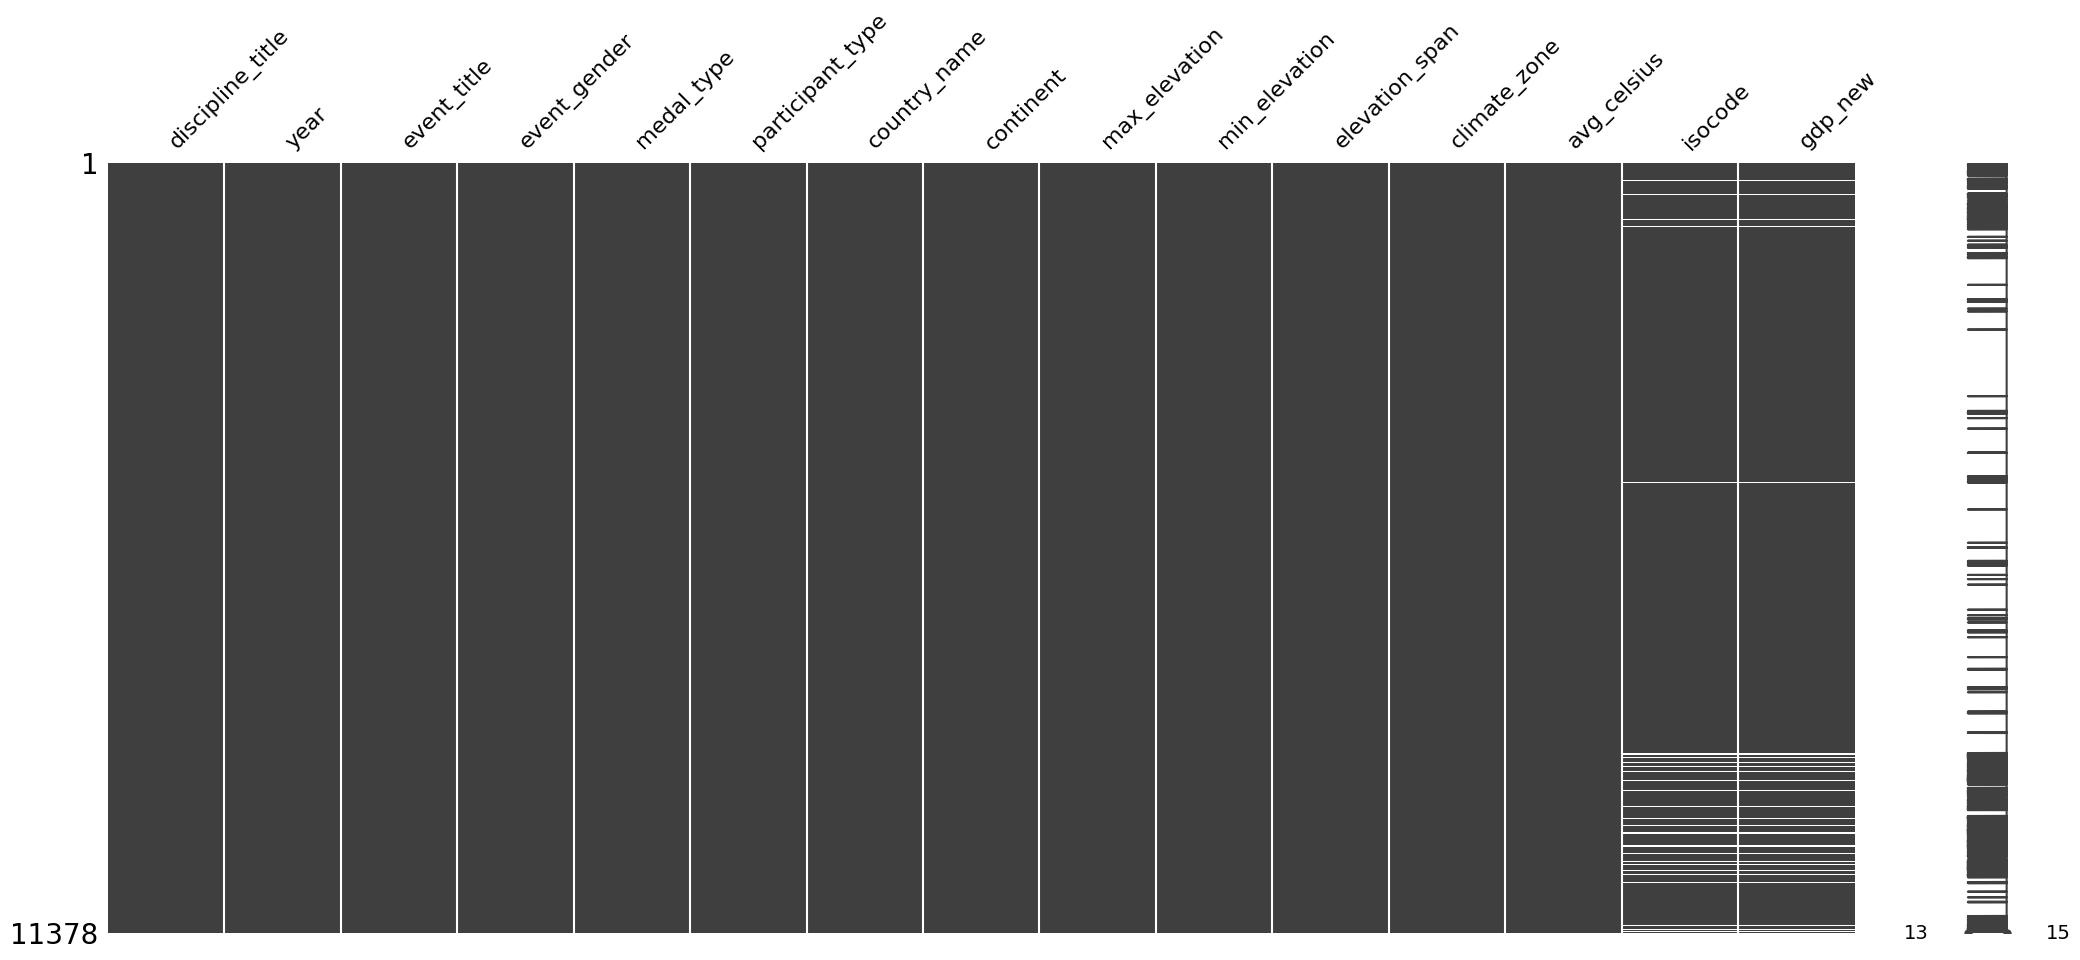

In [1335]:
msno.matrix(df_merged)

In [1346]:
print(df_merged.head(5))
print(df_merged.info())

  discipline_title  year    event_title event_gender medal_type  \
0          Curling  2022  Mixed Doubles        Mixed       GOLD   
1          Curling  2022  Mixed Doubles        Mixed     SILVER   
2          Curling  2022  Mixed Doubles        Mixed     BRONZE   
3          Curling  2022          Women        Women       GOLD   
4          Curling  2022          Women        Women     SILVER   

  participant_type    country_name continent  max_elevation  min_elevation  \
0         GameTeam           Italy    Europe         4810.0           -3.0   
1         GameTeam          Norway    Europe         2469.0            0.0   
2         GameTeam          Sweden    Europe         2097.0           -2.0   
3         GameTeam  United Kingdom    Europe         1345.0           -4.0   
4         GameTeam           Japan      Asia         3776.0           -4.0   

   elevation_span climate_zone  avg_celsius isocode       gdp_new  
0          4813.0          CSA        14.47     ITA  2.06697

## Data Exploration



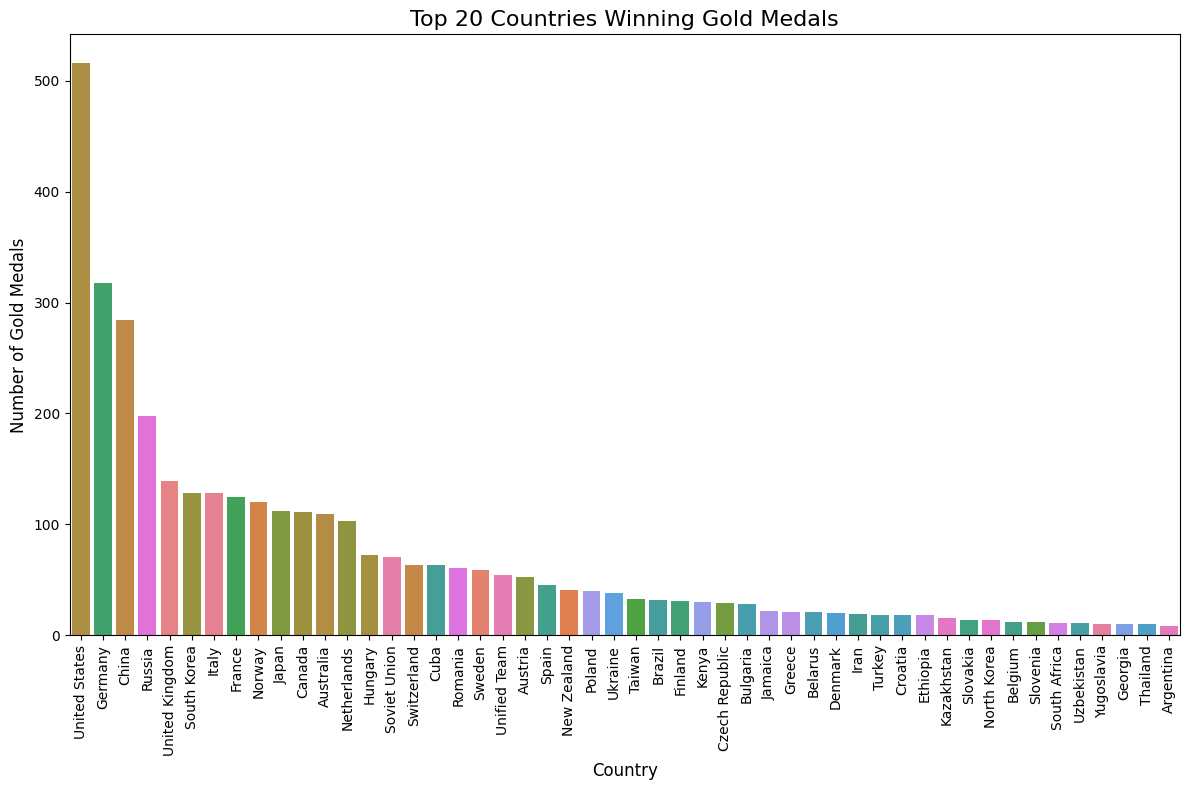

In [1347]:
gold_medals = df_merged[df_merged['medal_type'] == 'GOLD']
top_countries_gold = gold_medals['country_name'].value_counts().nlargest(50)

filtered_data_gold = gold_medals[gold_medals['country_name'].isin(top_countries_gold.index)]

plt.figure(figsize=(12, 8))
sns.countplot(
    x='country_name', 
    data=filtered_data_gold, 
    order=top_countries_gold.index,  
    hue='country_name'
)
plt.title('Top 20 Countries Winning Gold Medals', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Gold Medals', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

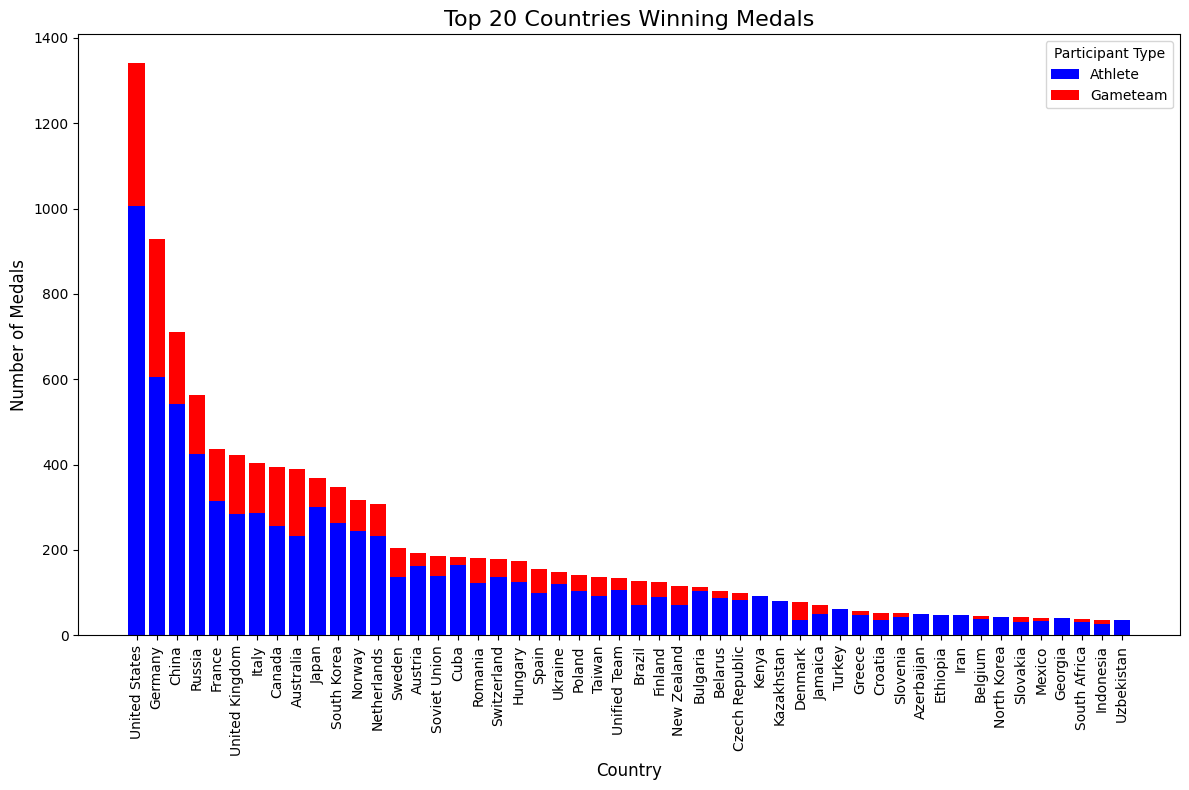

In [1348]:
participant_counts = df_merged.groupby(['country_name', 'participant_type']).size().unstack(fill_value=0)

participant_counts['total'] = participant_counts.sum(axis=1)
top_countries = participant_counts.nlargest(50, 'total')  
participant_counts = top_countries.drop(columns='total')  

plt.figure(figsize=(12, 8))
colors = {'Athlete': 'blue', 'GameTeam': 'red'}
bottom = None  

for participant_type in ['Athlete', 'GameTeam']:
    plt.bar(
        top_countries.index, 
        participant_counts[participant_type], 
        bottom=bottom, 
        label=participant_type.capitalize(), 
        color=colors[participant_type]
    )
    bottom = participant_counts[participant_type] if bottom is None else bottom + participant_counts[participant_type]

plt.title('Top 20 Countries Winning Medals', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Medals', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Participant Type', fontsize=10)
plt.tight_layout()

plt.show()

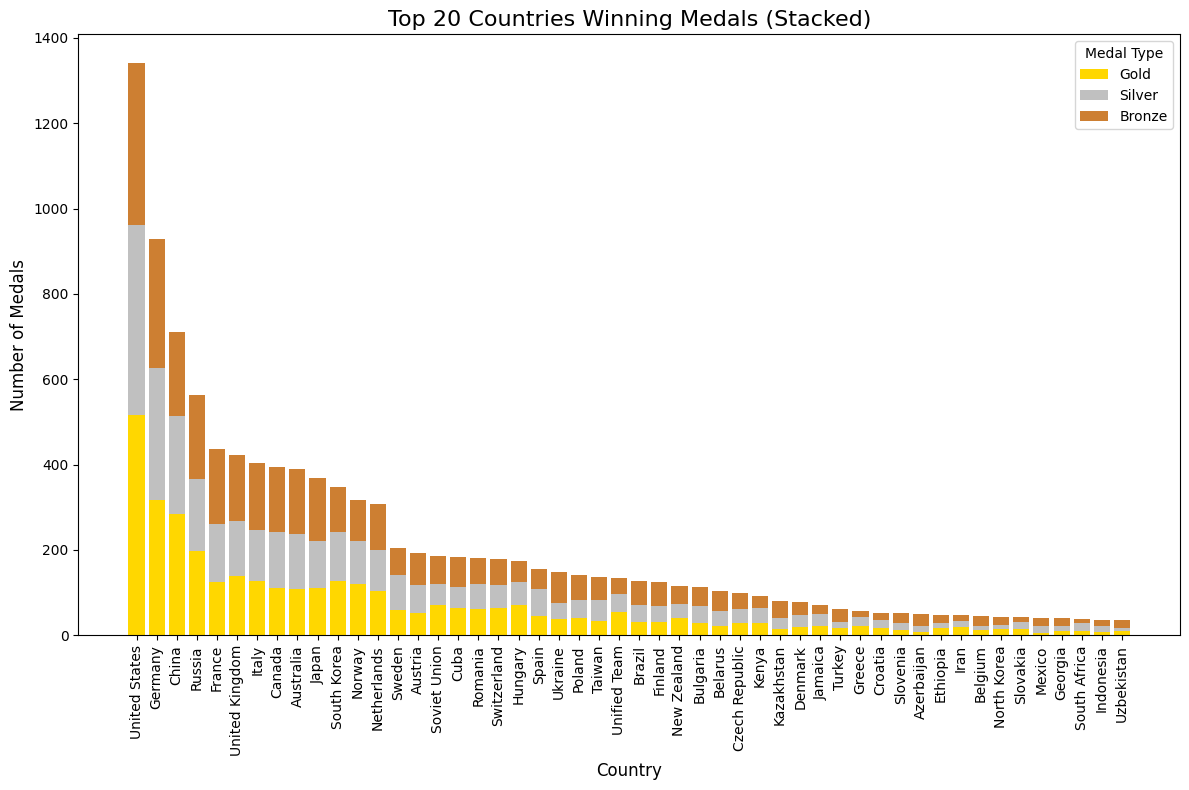

In [1349]:
medal_counts = df_merged.groupby(['country_name', 'medal_type']).size().unstack(fill_value=0)

medal_counts['total'] = medal_counts.sum(axis=1)
top_countries = medal_counts.nlargest(50, 'total')  
medal_counts = top_countries.drop(columns='total')  

plt.figure(figsize=(12, 8))
colors = {'GOLD': 'gold', 'SILVER': 'silver', 'BRONZE': '#cd7f32'}
bottom = None  

for medal_type in ['GOLD', 'SILVER', 'BRONZE']:
    plt.bar(
        top_countries.index, 
        medal_counts[medal_type], 
        bottom=bottom, 
        label=medal_type.capitalize(), 
        color=colors[medal_type]
    )
    bottom = medal_counts[medal_type] if bottom is None else bottom + medal_counts[medal_type]

plt.title('Top 50 Countries Winning Medals (Stacked)', fontsize=16)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Medals', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title='Medal Type', fontsize=10)
plt.tight_layout()

plt.show()


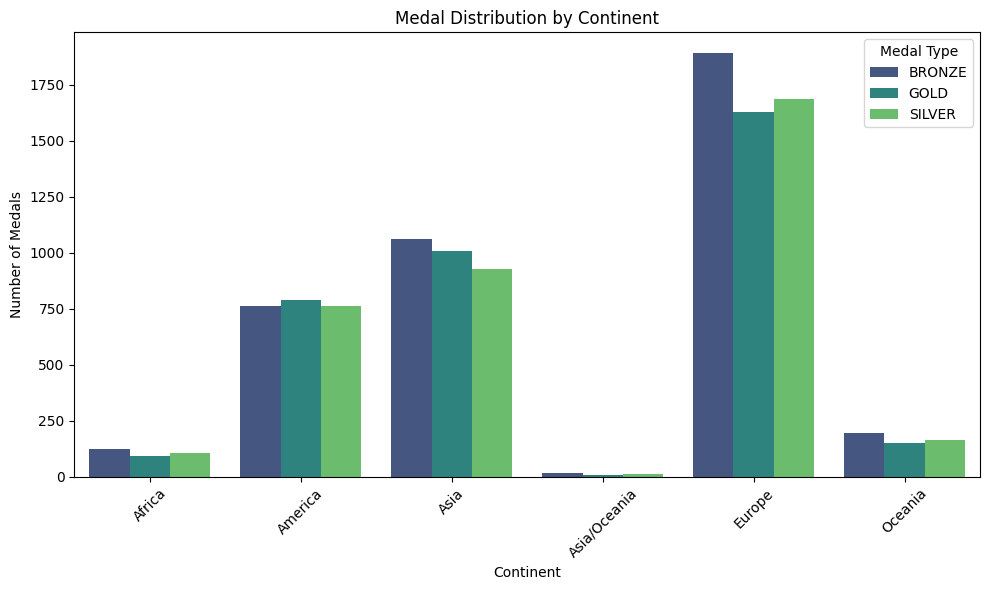

In [1350]:
continent_medal_count = df_merged.groupby(['continent', 'medal_type']).size().unstack()
continent_medal_count = continent_medal_count.reset_index().melt(id_vars=['continent'], var_name='Medal Type', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(data=continent_medal_count, x='continent', y='Count', hue='Medal Type', palette='viridis')
plt.title('Medal Distribution by Continent')
plt.ylabel('Number of Medals')
plt.xlabel('Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

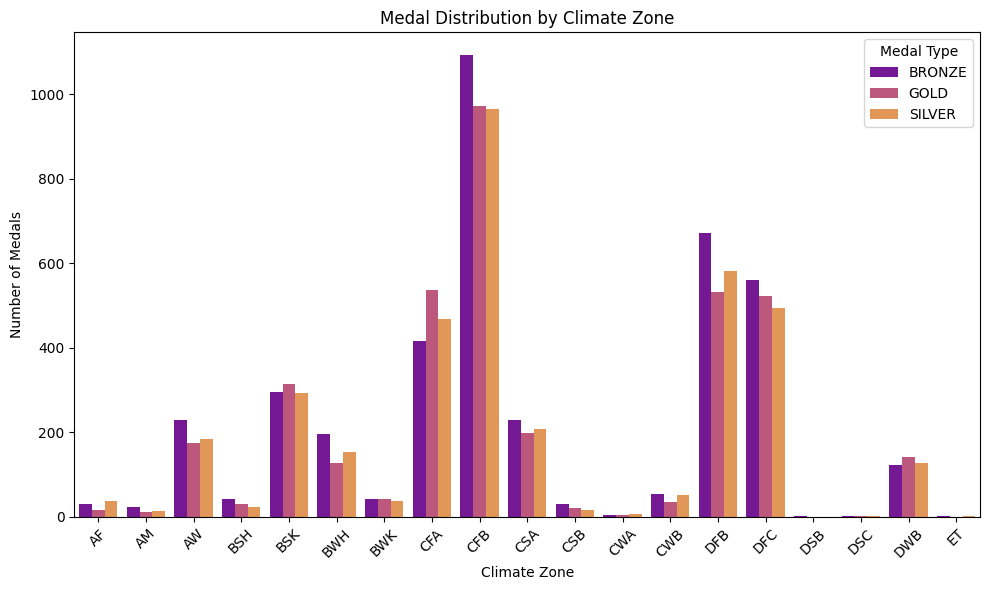

In [1351]:
climate_medals = df_merged.groupby(['climate_zone', 'medal_type']).size().unstack()
climate_medals = climate_medals.reset_index().melt(id_vars=['climate_zone'], var_name='Medal Type', value_name='Count')
plt.figure(figsize=(10, 6))
sns.barplot(data=climate_medals, x='climate_zone', y='Count', hue='Medal Type', palette='plasma')
plt.title('Medal Distribution by Climate Zone')
plt.ylabel('Number of Medals')
plt.xlabel('Climate Zone')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

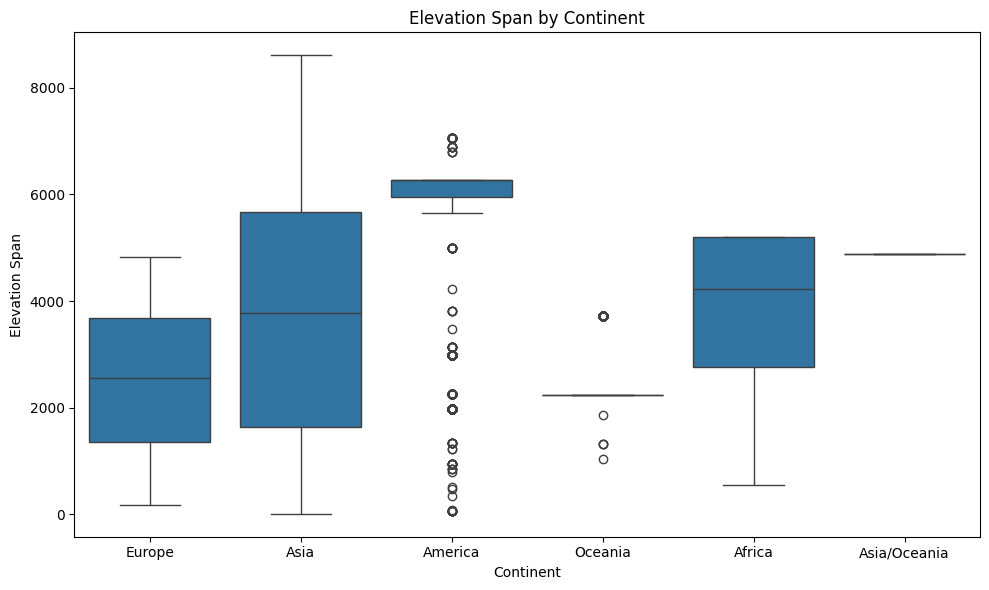

In [1352]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_merged, x='continent', y='elevation_span')
plt.title('Elevation Span by Continent')
plt.xlabel('Continent')
plt.ylabel('Elevation Span')
plt.tight_layout()
plt.show()

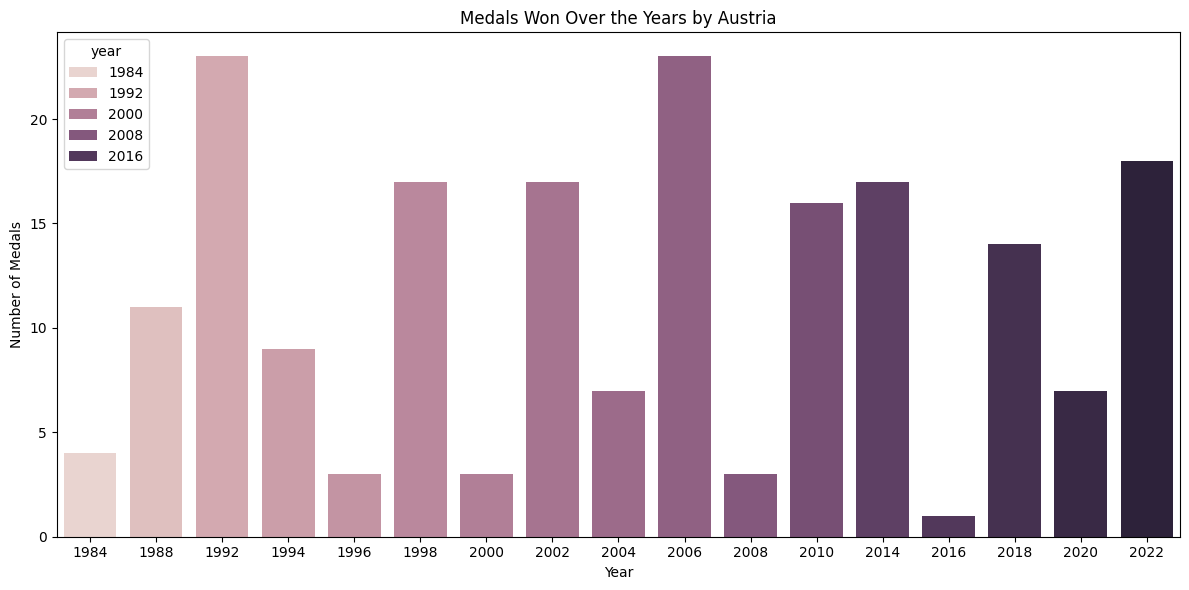

In [1353]:
df_austria = df_merged[df_merged['country_name']=='Austria'].groupby('year')['medal_type'].count().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=df_austria, x='year', y='medal_type', hue='year')
plt.title('Medals Won Over the Years by Austria')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.tight_layout()
plt.show()

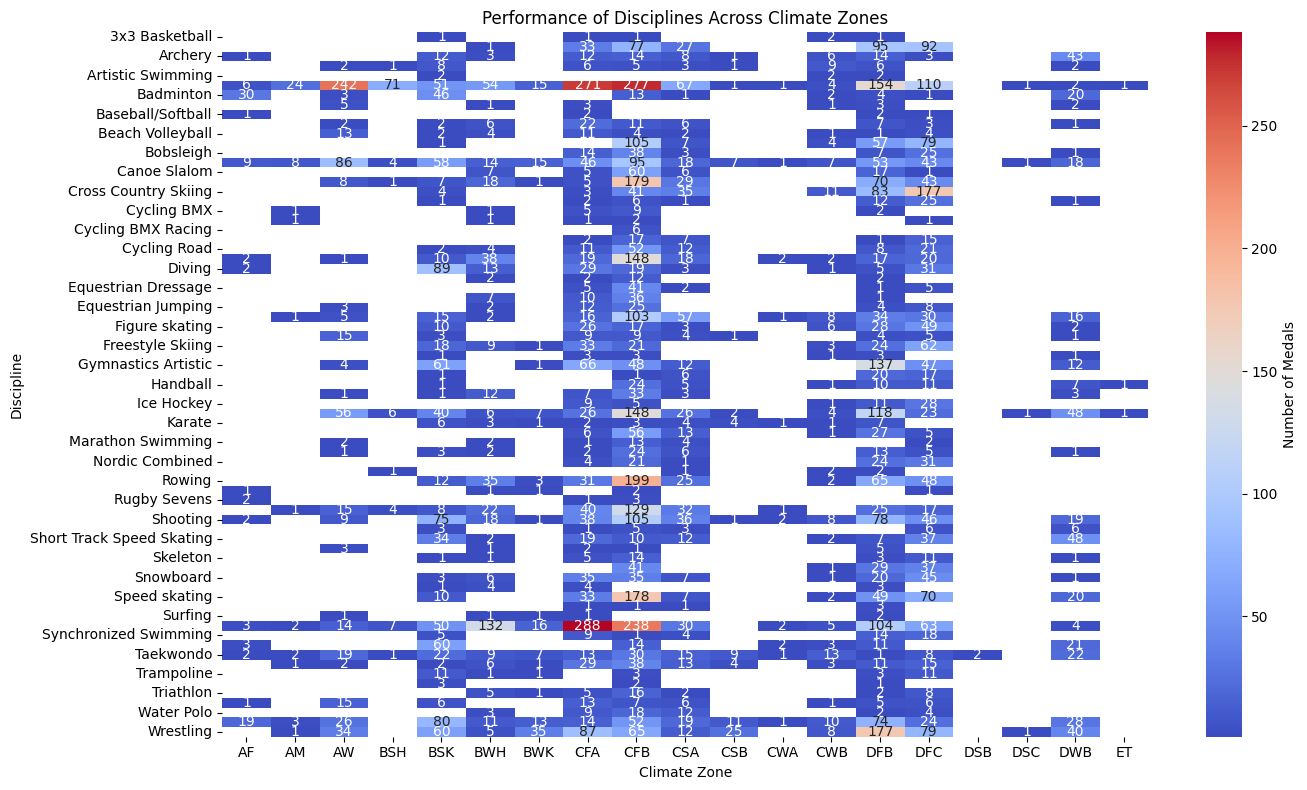

In [1354]:
discipline_climate = df_merged.groupby(['discipline_title', 'climate_zone']).size().reset_index(name='Count')
plt.figure(figsize=(14, 8))
heatmap_data = discipline_climate.pivot(index='discipline_title', columns='climate_zone', values='Count')
sns.heatmap(data=heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar_kws={'label': 'Number of Medals'})
plt.title('Performance of Disciplines Across Climate Zones')
plt.xlabel('Climate Zone')
plt.ylabel('Discipline')
plt.tight_layout()
plt.show()

/var/folders/4j/v1g8gthx209g90f63vh1krc80000gn/T/ipykernel_80788/175997145.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


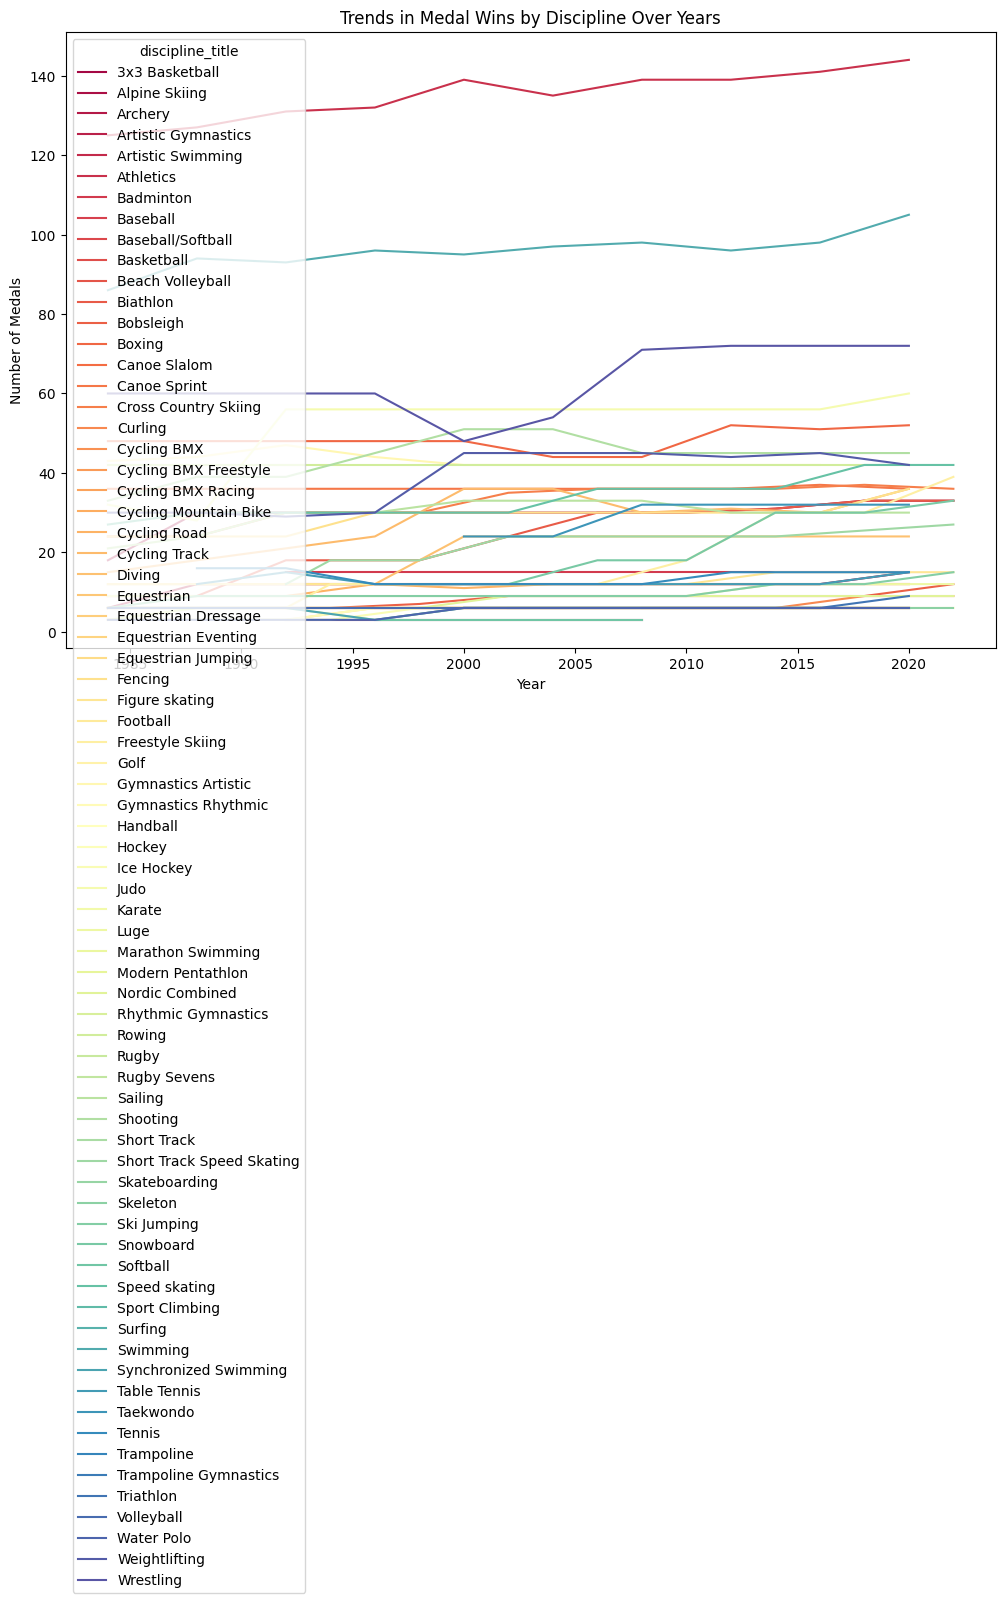

In [1355]:
plt.figure(figsize=(12, 8))
season_medals = df_merged.groupby(['discipline_title', 'year']).size().reset_index(name='Count')
sns.lineplot(data=season_medals, x='year', y='Count', hue='discipline_title', palette='Spectral')
plt.title('Trends in Medal Wins by Discipline Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Medals')
plt.tight_layout()
plt.show()

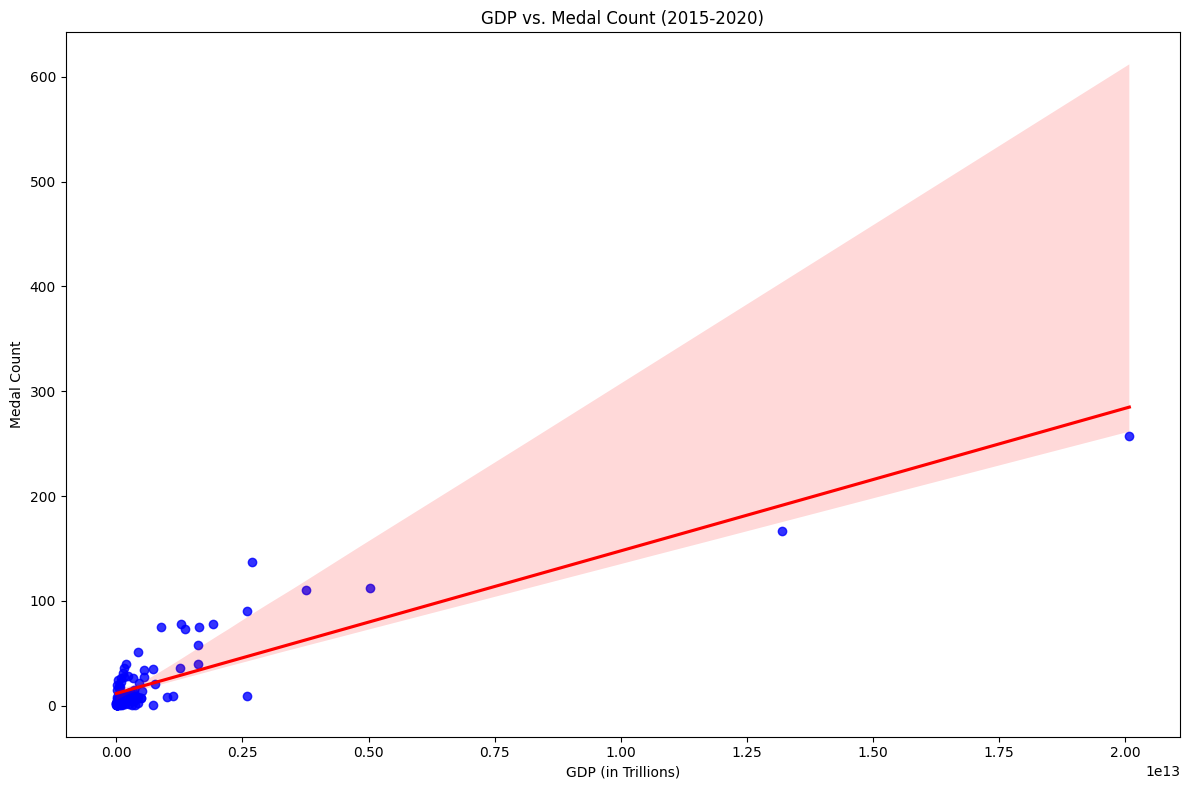

In [1356]:
filtered_data = df_merged[(df_merged['year'] >= 2015) & (df_merged['year'] <= 2020)]

# Group data by country and sum up GDP and medals
gdp_medals = filtered_data.groupby('country_name').agg({'gdp_new': 'mean', 'medal_type': 'count'}).reset_index()
gdp_medals.rename(columns={'medal_type': 'Medal Count'}, inplace=True)

# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(data=gdp_medals, x='gdp_new', y='Medal Count', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('GDP vs. Medal Count (2015-2020)')
plt.xlabel('GDP (in Trillions)')
plt.ylabel('Medal Count')
plt.tight_layout()
plt.show()

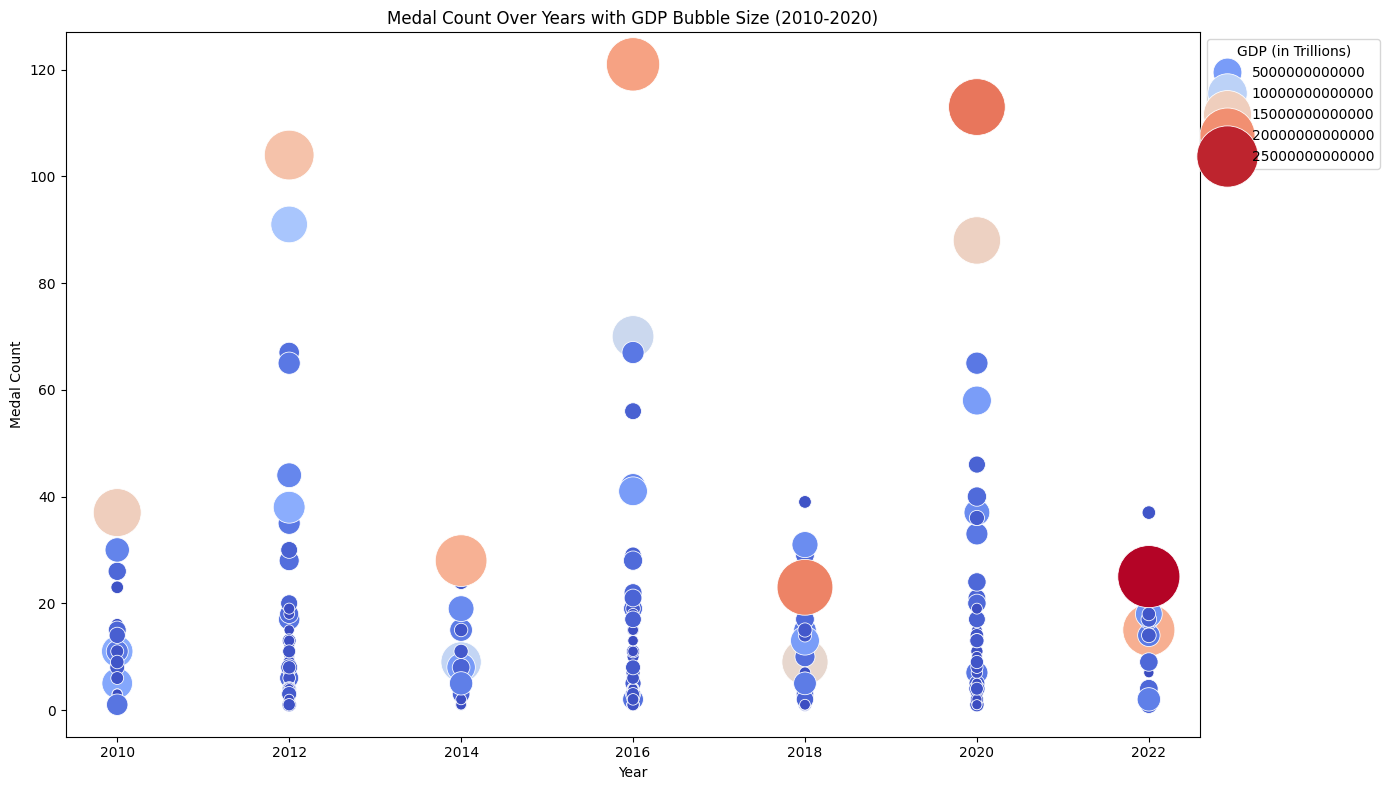

In [1359]:
filtered_data = df_merged[df_merged['year'].isin([2010, 2012, 2014, 2016, 2018, 2020, 2022])]

# Group data by year and country
yearly_gdp_medals = filtered_data.groupby(['year', 'country_name']).agg({'gdp_new': 'mean', 'medal_type': 'count'}).reset_index()
yearly_gdp_medals.rename(columns={'medal_type': 'Medal Count'}, inplace=True)

# Bubble plot
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=yearly_gdp_medals,
    x='year',
    y='Medal Count',
    size='gdp_new',
    hue='gdp_new',
    sizes=(50, 2000),
    palette='coolwarm'
)
plt.title('Medal Count Over Years with GDP Bubble Size (2010-2020)')
plt.xlabel('Year')
plt.ylabel('Medal Count')
plt.legend(title='GDP (in Trillions)', loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()